<a href="https://colab.research.google.com/github/samitnitrkl/BSSLecture/blob/main/notebook_icp_explainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Install required packages
!pip install openpyxl shap xgboost -q

# Standard library imports
import os        # operating system utilities
import glob      # filename pattern matching

# Numerical & data handling libraries
import numpy as np        # numerical arrays and random seeding
import pandas as pd       # dataframes and tabular data IO

# Plotting
import matplotlib.pyplot as plt  # plotting library (used for quick visualizations)

# Scikit-learn utilities for model building & evaluation
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer   # SimpleImputer: handle missing values (mean, median, most_frequent, constant)
from sklearn.preprocessing import StandardScaler # StandardScaler: scale features to zero mean and unit variance (important for some models)
from sklearn.linear_model import LassoCV # LassoCV: L1-regularized linear regression with built-in cross-validation to choose alpha
from sklearn.ensemble import RandomForestRegressor # RandomForestRegressor: ensemble tree-based regressor (robust, handles nonlinearities)
from sklearn.metrics import mean_squared_error, r2_score # mean_squared_error: regression loss metric (MSE/RMSE), r2_score: coefficient of determination (explained variance)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay # permutation_importance: feature importance via shuffling feature values, PartialDependenceDisplay: plot partial dependence (how target depends on a feature)

# SHAP (SHapley Additive exPlanations) for model interpretability
import shap
# Initialize JavaScript visualization code for SHAP plots in notebooks
shap.initjs()

RANDOM_STATE = 42  # Reproducibility: set a global random seed
np.random.seed(RANDOM_STATE)
print("Setup done.")

Setup done.


In [27]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/My Drive/Features/CHARIS/Duration_20_Increment_10"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
excel_files = glob.glob(os.path.join(data_dir, "*.xlsx"))
dfs = [pd.read_excel(f) for f in excel_files]
data = pd.concat(dfs, ignore_index=True)
# Print the shape of the dataset
print("Data Shape:", data.shape)
# Remove rows that contain at least one NaN (missing) value
data = data.dropna()
# Print the final shape of the combined and cleaned dataset
print("Combined shape after removing NaN rows:", data.shape)

Data Shape: (151130, 49)
Combined shape after removing NaN rows: (150627, 49)


In [29]:
data.head(150627)

,Record,Segment,SBP_mean,DBP_mean,PP_mean,...,ABP_Pslow_rel,ABP_Presp_rel,ABP_Pcard_rel,ABP_SpecCentroid,ABP_SpecEntropy
0,charis8,1,122.415969,86.663473,35.752496,...,0.001630,0.004826,0.879374,12.991571,0.902509
1,charis8,2,123.233177,91.542205,31.690971,...,0.003057,0.006328,0.864661,13.158910,0.830980
2,charis8,3,122.732922,88.781537,33.951384,...,0.000717,0.004500,0.863913,13.332838,0.790580
3,charis8,4,128.161323,102.461372,25.699952,...,0.000827,0.004420,0.967224,9.151160,0.292151
4,charis8,5,128.004140,105.799060,22.205081,...,0.000109,0.004026,0.968333,9.175834,0.283004
...,...,...,...,...,...,...,...,...,...,...,...
151125,charis10,5631,126.505272,91.942675,34.562597,...,0.005007,0.010932,0.927109,11.240720,0.199362
151126,charis10,5632,124.168730,89.900281,34.268449,...,0.004604,0.010964,0.923892,11.317162,0.218782
151127,charis10,5633,121.974478,84.877298,37.097180,...,0.001869,0.010169,0.923957,11.442140,0.227028
151128,charis10,5634,125.951092,91.139697,34.811396,...,0.001574,0.008988,0.930898,11.305825,0.183332


In [30]:
all_cols = data.columns.tolist()
print("Columns:", all_cols)

Columns: ['Record', 'Segment', 'SBP_mean', 'DBP_mean', 'PP_mean', 'MAP_mean', 'HR_mean', 'ICP_mean', 'Tpi_mean', 'Tpp_mean', 'Tsys_mean', 'Tsp_mean', 'Tdp_mean', 'dT_mean', 'Tswx_mean', 'Tdwx_mean', 'Tpwx_mean', 'Asp_mean', 'Adn_mean', 'Adp_mean', 'Aoff_mean', 'AUCpi_mean', 'AUCsys_mean', 'IPR_mean', 'RI_mean', 'SI_mean', 'MeanMax_dABPdt', 'MeanMin_dABPdt', 'MeanMax_d2ABPdt2', 'MeanMin_d2ABPdt2', 'Mean_Mean_dABPdt_perBeat', 'Mean_Mean_d2ABPdt2_perBeat', 'Mean_RMS_dABPdt_perBeat', 'Mean_RMS_d2ABPdt2_perBeat', 'Mean_AreaAbs_dABPdt', 'Mean_AreaAbs_d2ABPdt2', 'Mean_RelPos_Max_dABPdt', 'Mean_RelPos_Min_dABPdt', 'Mean_RelPos_Max_d2ABPdt2', 'Mean_RelPos_Min_d2ABPdt2', 'ABP_Ptot', 'ABP_Pslow', 'ABP_Presp', 'ABP_Pcard', 'ABP_Pslow_rel', 'ABP_Presp_rel', 'ABP_Pcard_rel', 'ABP_SpecCentroid', 'ABP_SpecEntropy']


In [31]:
y = data["ICP_mean"].values
drop_cols = ["Record", "Segment", "ICP_mean"]
feature_cols = [c for c in data.columns if c not in drop_cols]
X = data[feature_cols]
print("Original features:", len(feature_cols))

Original features: 46


In [32]:
from sklearn.feature_selection import VarianceThreshold
# Variance threshold: remove near-constant features
var_thresh = 1e-4  # adjust if your features are large/small in scale
vt = VarianceThreshold(threshold=var_thresh)
vt_fit = vt.fit(X.fillna(0))  # fillna only for variance check (we dropped NaN rows already)
keep_mask = vt_fit.get_support()
features_after_variance = X.columns[keep_mask].tolist()
print("Features after variance filter:", len(features_after_variance))
X_var = X[features_after_variance]

Features after variance filter: 43


In [33]:
# Features dropped by variance threshold
dropped_features = X.columns[~keep_mask].tolist()

print("Dropped features (variance < {:.0e}):".format(var_thresh))
for f in dropped_features:
    print(f)
print("Number of dropped features:", len(dropped_features))

Dropped features (variance < 1e-04):
Tdwx_mean
ABP_Pslow_rel
ABP_Presp_rel
Number of dropped features: 3


In [34]:
variances = X.var()
print("\nDropped features with variance:")
for f in dropped_features:
    print(f, "=", variances[f])


Dropped features with variance:
Tdwx_mean = 3.977013680720301e-06
ABP_Pslow_rel = 2.482346760598943e-05
ABP_Presp_rel = 4.15328693376598e-05


In [35]:
# Correlation filter: drop one of any pair with abs(corr) > threshold
corr_thresh = 0.90
corr_mat = X_var.corr().abs()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > corr_thresh)]
features_after_corr = [c for c in X_var.columns if c not in to_drop]
print("Features after correlation filter (drop highly collinear):", len(features_after_corr))

X_corr = X_var[features_after_corr].copy()

Features after correlation filter (drop highly collinear): 31


In [36]:
# after computing to_drop as in your original snippet
dropped_by_corr = to_drop
print("Dropped due to high correlation (abs > {:.2f}):".format(corr_thresh))
for f in dropped_by_corr:
    print(f)

Dropped due to high correlation (abs > 0.90):
Tsys_mean
Tdp_mean
dT_mean
Tpwx_mean
Asp_mean
Adp_mean
Aoff_mean
AUCsys_mean
MeanMax_d2ABPdt2
Mean_RMS_d2ABPdt2_perBeat
Mean_AreaAbs_d2ABPdt2
ABP_Pcard


Correlation matrix shape: (31, 31)

Correlation matrix (showing top-left corner / truncated if large):


,SBP_mean,DBP_mean,PP_mean,MAP_mean,HR_mean,...,Tsp_mean,Tswx_mean,Adn_mean,AUCpi_mean,IPR_mean
SBP_mean,1.000000,0.773689,0.095546,0.699111,-0.027946,...,-0.259623,-0.266551,-0.316217,0.478671,-0.086808
DBP_mean,0.773689,1.000000,-0.556744,0.611539,-0.040389,...,-0.719202,-0.381386,-0.798633,0.780333,-0.535537
PP_mean,0.095546,-0.556744,1.000000,-0.044196,0.026816,...,0.789574,0.249731,0.840170,-0.598421,0.727590
MAP_mean,0.699111,0.611539,-0.044196,1.000000,0.074948,...,-0.193796,-0.238636,-0.069607,0.398847,0.074993
HR_mean,-0.027946,-0.040389,0.026816,0.074948,1.000000,...,-0.047819,-0.248548,0.122889,-0.478937,0.418205
Tpi_mean,0.190381,0.554153,-0.621043,-0.044288,-0.580236,...,-0.560533,-0.032940,-0.767885,0.888581,-0.813160
Tpp_mean,0.017341,-0.025978,0.063552,-0.182864,-0.799068,...,0.125355,0.284421,-0.071001,0.507596,-0.310995
Tsp_mean,-0.259623,-0.719202,0.789574,-0.193796,-0.047819,...,1.000000,0.601389,0.824915,-0.594908,0.484263
Tswx_mean,-0.266551,-0.381386,0.249731,-0.238636,-0.248548,...,0.601389,1.000000,0.267027,-0.127683,-0.170279
Adn_mean,-0.316217,-0.798633,0.840170,-0.069607,0.122889,...,0.824915,0.267027,1.000000,-0.739718,0.820677



Saved full correlation matrix to 'correlation_matrix_after_filter.csv'


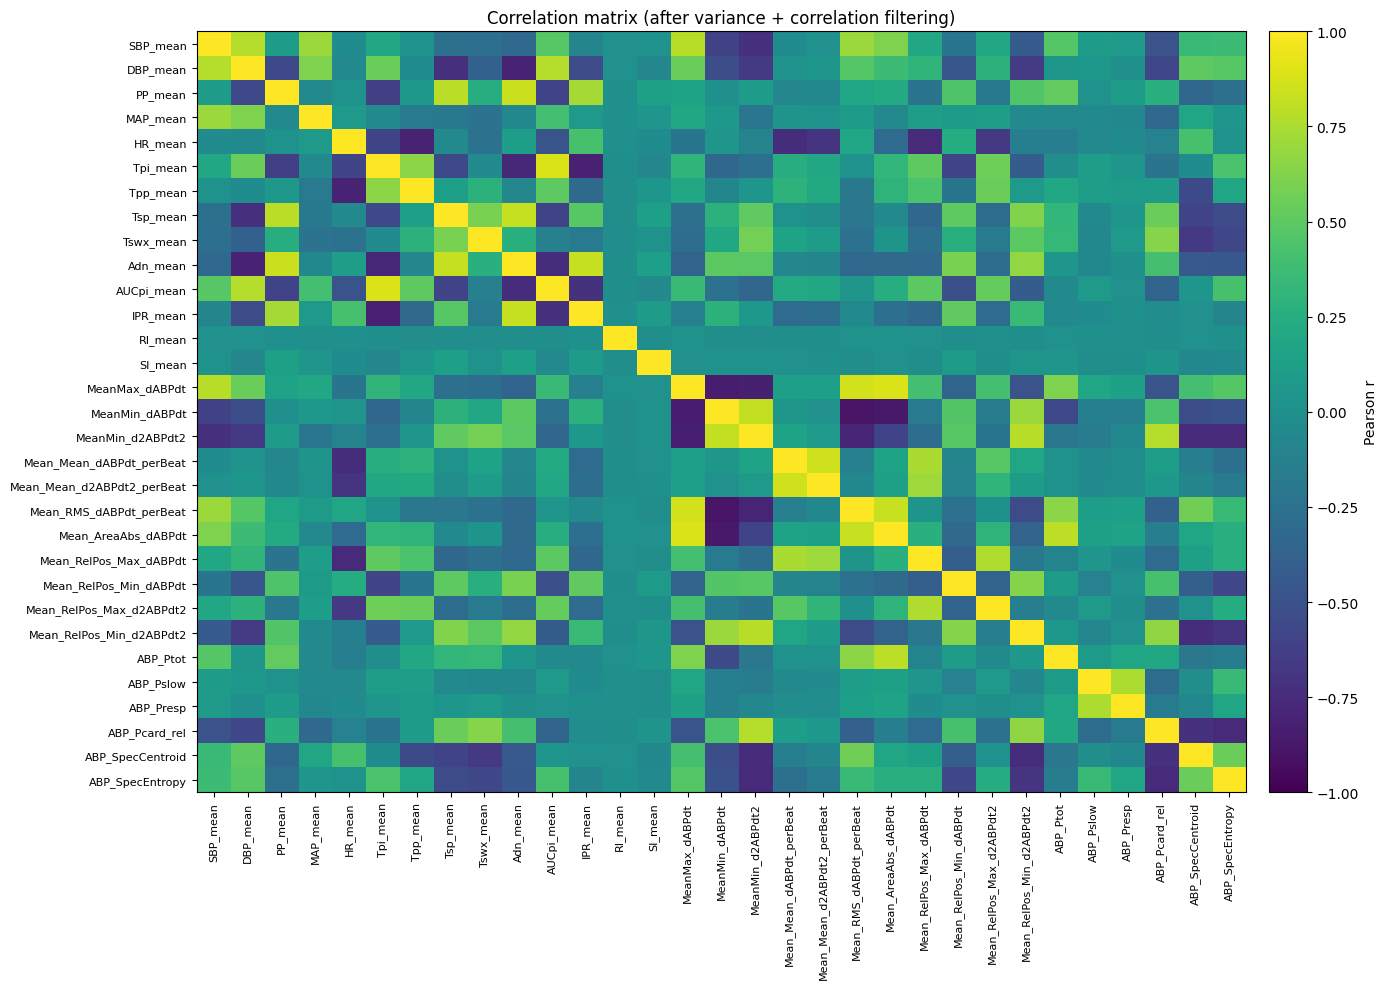

In [37]:
# Correlation matrix of the remaining features
corr_after = X_corr.corr()   # signed Pearson correlations

# Print a digest if there are many features
print("Correlation matrix shape:", corr_after.shape)
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 10)
print("\nCorrelation matrix (showing top-left corner / truncated if large):")
display(corr_after.head(12).T.head(12))   # show a trimmed corner for quick inspection

# Save full correlation matrix to CSV for inspection in Excel
corr_after.to_csv("correlation_matrix_after_filter.csv")
print("\nSaved full correlation matrix to 'correlation_matrix_after_filter.csv'")

# 5) Plot heatmap (annotate if small number of features)
n_feats = corr_after.shape[0]
fig, ax = plt.subplots(figsize=(min(14, 0.4*n_feats + 4), min(10, 0.35*n_feats + 4)))
im = ax.imshow(corr_after.values, aspect="auto", vmin=-1, vmax=1)
ax.set_xticks(range(n_feats))
ax.set_yticks(range(n_feats))
ax.set_xticklabels(corr_after.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr_after.index, fontsize=8)
plt.colorbar(im, ax=ax, fraction=0.04, pad=0.02, label="Pearson r")
ax.set_title("Correlation matrix (after variance + correlation filtering)")
plt.tight_layout()

# annotate numeric values when there are not many features
if n_feats <= 30:
    for i in range(n_feats):
        for j in range(n_feats):
            val = corr_after.values[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7,
                    color="white" if abs(val) > 0.5 else "black")
plt.show()


In [38]:
print("Final selected features (after var+corr):")
print(list(X_corr.columns))


Final selected features (after var+corr):
['SBP_mean', 'DBP_mean', 'PP_mean', 'MAP_mean', 'HR_mean', 'Tpi_mean', 'Tpp_mean', 'Tsp_mean', 'Tswx_mean', 'Adn_mean', 'AUCpi_mean', 'IPR_mean', 'RI_mean', 'SI_mean', 'MeanMax_dABPdt', 'MeanMin_dABPdt', 'MeanMin_d2ABPdt2', 'Mean_Mean_dABPdt_perBeat', 'Mean_Mean_d2ABPdt2_perBeat', 'Mean_RMS_dABPdt_perBeat', 'Mean_AreaAbs_dABPdt', 'Mean_RelPos_Max_dABPdt', 'Mean_RelPos_Min_dABPdt', 'Mean_RelPos_Max_d2ABPdt2', 'Mean_RelPos_Min_d2ABPdt2', 'ABP_Ptot', 'ABP_Pslow', 'ABP_Presp', 'ABP_Pcard_rel', 'ABP_SpecCentroid', 'ABP_SpecEntropy']


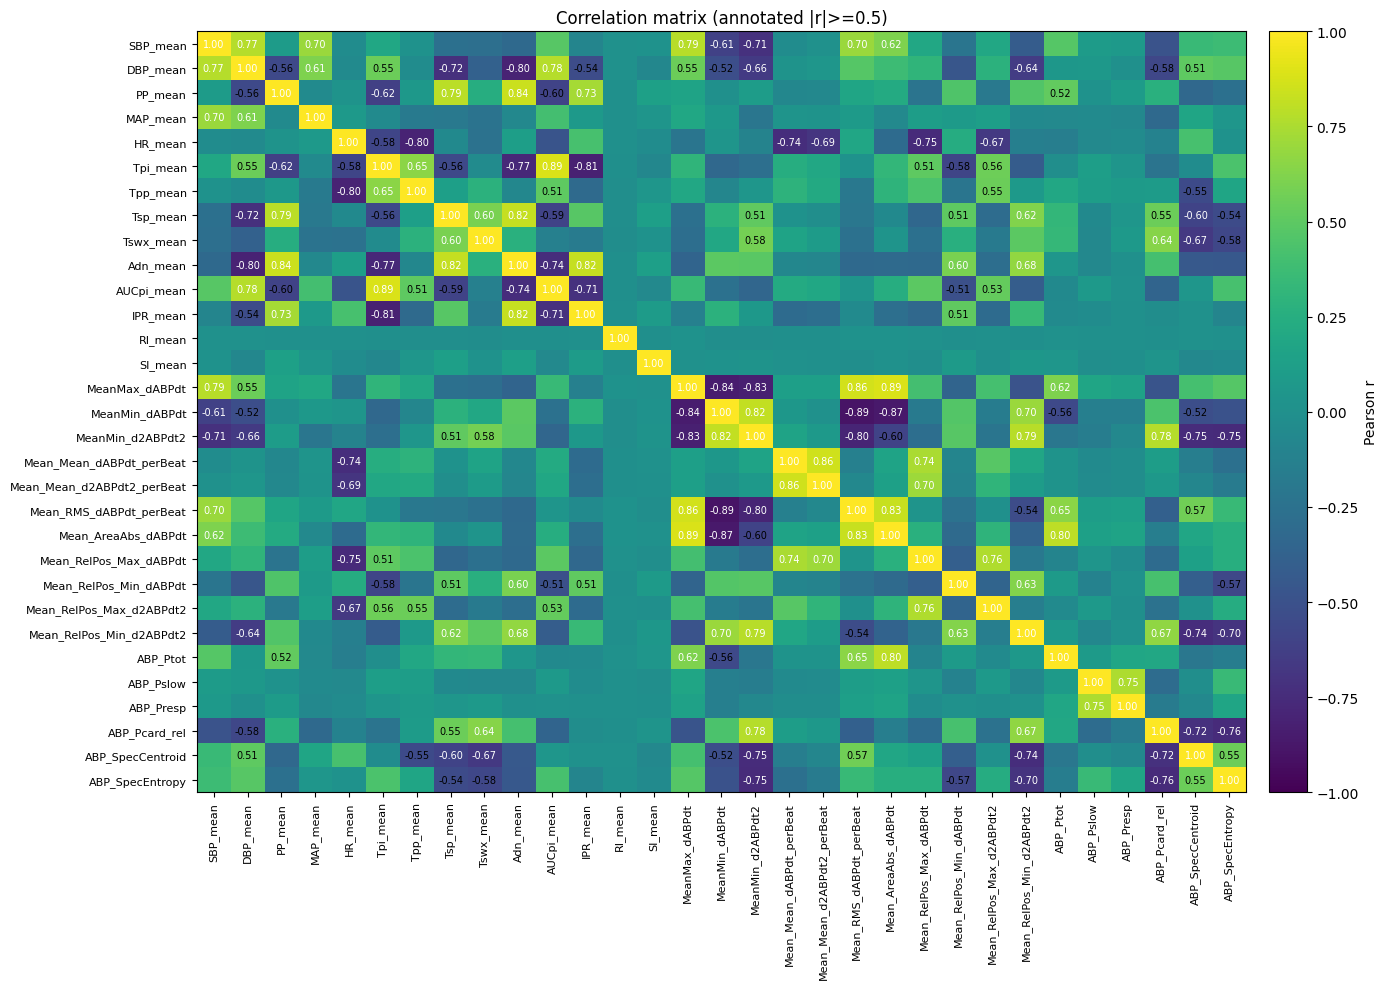

In [39]:
fig, ax = plt.subplots(figsize=(min(14, 0.4*n_feats + 4), min(10, 0.35*n_feats + 4)))
im = ax.imshow(corr_after.values, aspect="auto", vmin=-1, vmax=1)
ax.set_xticks(range(n_feats)); ax.set_yticks(range(n_feats))
ax.set_xticklabels(corr_after.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr_after.index, fontsize=8)
plt.colorbar(im, ax=ax, fraction=0.04, pad=0.02, label="Pearson r")
threshold_annot = 0.5
for i in range(n_feats):
    for j in range(n_feats):
        val = corr_after.values[i, j]
        if abs(val) >= threshold_annot:
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7,
                    color="white" if abs(val) > 0.6 else "black")
ax.set_title(f"Correlation matrix (annotated |r|>={threshold_annot})")
plt.tight_layout()
plt.show()


In [48]:
# Prepare X and y using the final filtered features
X_final = X_corr.copy()              # DataFrame of features after var+corr
y_series = y if isinstance(y, pd.Series) else pd.Series(y, index=X_final.index)

print("Final features count:", X_final.shape[1])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_series, test_size=0.3, random_state=RANDOM_STATE
)
print("Train / test sizes:", X_train.shape, X_test.shape)

Final features count: 31
Train / test sizes: (105438, 31) (45189, 31)


In [49]:
# LASSO selection on training set (scale first)
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

lasso = LassoCV(cv=5, random_state=RANDOM_STATE, n_alphas=50, max_iter=5000)
lasso.fit(X_train_s, y_train)
lasso_selected = X_train_s.columns[lasso.coef_ != 0].tolist()
print("\nLASSO selected (non-zero coef):", len(lasso_selected))
print(lasso_selected)


LASSO selected (non-zero coef): 28
['SBP_mean', 'MAP_mean', 'HR_mean', 'Tpi_mean', 'Tpp_mean', 'Tsp_mean', 'Tswx_mean', 'Adn_mean', 'AUCpi_mean', 'IPR_mean', 'RI_mean', 'SI_mean', 'MeanMax_dABPdt', 'MeanMin_dABPdt', 'MeanMin_d2ABPdt2', 'Mean_Mean_dABPdt_perBeat', 'Mean_Mean_d2ABPdt2_perBeat', 'Mean_RMS_dABPdt_perBeat', 'Mean_AreaAbs_dABPdt', 'Mean_RelPos_Max_dABPdt', 'Mean_RelPos_Min_dABPdt', 'Mean_RelPos_Min_d2ABPdt2', 'ABP_Ptot', 'ABP_Pslow', 'ABP_Presp', 'ABP_Pcard_rel', 'ABP_SpecCentroid', 'ABP_SpecEntropy']


In [55]:

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

coef_df = pd.DataFrame({
    "feature": X_train_s.columns,
    "coef": lasso.coef_
}).set_index("feature").sort_values("coef", key=lambda s: s.abs(), ascending=False)

print("LASSO chosen alpha:", lasso.alpha_)
print("\nTop coefficients (abs sorted):")
print(coef_df.head(40).to_string())


LASSO chosen alpha: 0.0029094795680596284

Top coefficients (abs sorted):
                                coef
feature                             
MeanMin_d2ABPdt2            9.322507
Tpi_mean                   -6.768031
ABP_SpecCentroid            6.633920
AUCpi_mean                  5.817656
MeanMax_dABPdt              5.065944
SBP_mean                    3.730765
ABP_SpecEntropy             3.503899
Adn_mean                   -3.225530
MAP_mean                   -2.765193
MeanMin_dABPdt              2.056571
Mean_AreaAbs_dABPdt        -1.894287
Tpp_mean                    1.785294
Mean_RelPos_Max_dABPdt     -1.732381
Mean_RMS_dABPdt_perBeat     1.712808
HR_mean                    -1.420224
Mean_RelPos_Min_d2ABPdt2    1.233228
IPR_mean                    1.195360
ABP_Pcard_rel               0.906129
Mean_RelPos_Min_dABPdt     -0.886546
Tswx_mean                   0.863895
ABP_Pslow                   0.757402
ABP_Ptot                   -0.681745
ABP_Presp                  -0.432106
M

In [57]:
candidate_features = list(lasso_selected)
print("Using candidate features (count):", len(candidate_features))
print(candidate_features)

Using candidate features (count): 28
['SBP_mean', 'MAP_mean', 'HR_mean', 'Tpi_mean', 'Tpp_mean', 'Tsp_mean', 'Tswx_mean', 'Adn_mean', 'AUCpi_mean', 'IPR_mean', 'RI_mean', 'SI_mean', 'MeanMax_dABPdt', 'MeanMin_dABPdt', 'MeanMin_d2ABPdt2', 'Mean_Mean_dABPdt_perBeat', 'Mean_Mean_d2ABPdt2_perBeat', 'Mean_RMS_dABPdt_perBeat', 'Mean_AreaAbs_dABPdt', 'Mean_RelPos_Max_dABPdt', 'Mean_RelPos_Min_dABPdt', 'Mean_RelPos_Min_d2ABPdt2', 'ABP_Ptot', 'ABP_Pslow', 'ABP_Presp', 'ABP_Pcard_rel', 'ABP_SpecCentroid', 'ABP_SpecEntropy']


In [62]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

final_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=500, max_depth=6,
                               learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
                               random_state=RANDOM_STATE, n_jobs=-1)
final_model.fit(X_train[candidate_features], y_train)
y_pred_final = final_model.predict(X_test[candidate_features])


In [63]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn

# show sklearn version
print("scikit-learn version:", sklearn.__version__)

# ensure 1-D numeric arrays with matching length
y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred_final)
print("y_true shape:", y_true.shape, "y_pred shape:", y_pred.shape)

# compute metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Final model test RMSE: {rmse:.4f}")
print(f"Final model test MAE : {mae:.4f}")
print(f"Final model test R2  : {r2:.4f}")

scikit-learn version: 1.6.1
y_true shape: (45189,) y_pred shape: (45189,)
Final model test RMSE: 3.0240
Final model test MAE : 2.0839
Final model test R2  : 0.8017


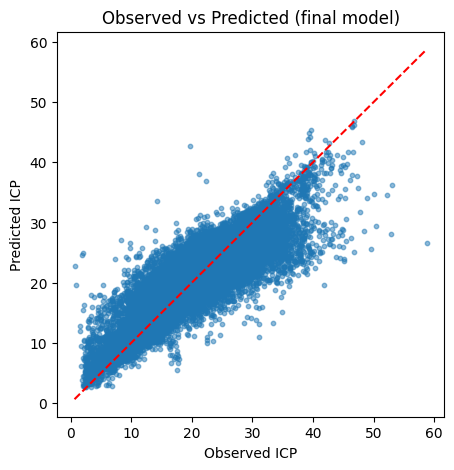

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.5, s=10)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("Observed ICP")
plt.ylabel("Predicted ICP")
plt.title("Observed vs Predicted (final model)")
plt.show()


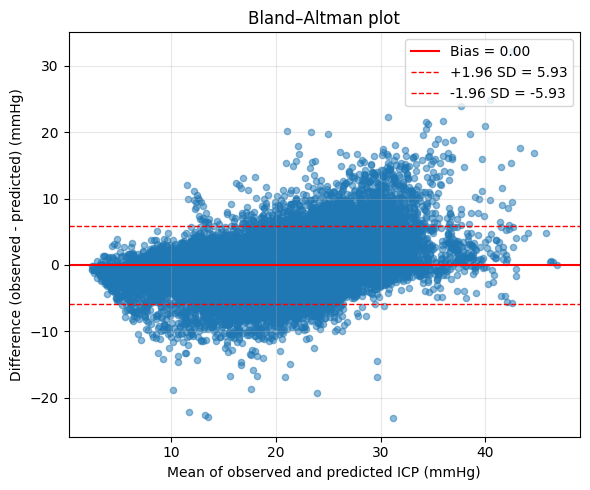

Bland–Altman summary:
  N = 45189
  Mean bias = 0.001 mmHg
  SD of differences = 3.024 mmHg
  95% LoA = [-5.926, 5.928] mmHg
Saved: figures/bland_altman.png


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import os

#
y_true = np.ravel(y_test)         # observed
y_pred = np.ravel(y_pred_final)   # predicted

mean_vals = (y_true + y_pred) / 2.0
diffs = y_true - y_pred           # observed - predicted
bias = np.mean(diffs)             # mean difference
sd_diff = np.std(diffs, ddof=1)   # sample std

# Limits of agreement (95%)
loa_upper = bias + 1.96 * sd_diff
loa_lower = bias - 1.96 * sd_diff

# Plot
out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)
plt.figure(figsize=(6,5))
plt.scatter(mean_vals, diffs, alpha=0.5, s=20)
plt.axhline(bias, color='red', linestyle='-', linewidth=1.5, label=f"Bias = {bias:.2f}")
plt.axhline(loa_upper, color='red', linestyle='--', linewidth=1, label=f"+1.96 SD = {loa_upper:.2f}")
plt.axhline(loa_lower, color='red', linestyle='--', linewidth=1, label=f"-1.96 SD = {loa_lower:.2f}")

plt.xlabel("Mean of observed and predicted ICP (mmHg)")
plt.ylabel("Difference (observed - predicted) (mmHg)")
plt.title("Bland–Altman plot")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()

fname = os.path.join(out_dir, "bland_altman.png")
plt.savefig(fname, dpi=300, bbox_inches='tight')
plt.show()

# Print numeric summary
print("Bland–Altman summary:")
print(f"  N = {len(diffs)}")
print(f"  Mean bias = {bias:.3f} mmHg")
print(f"  SD of differences = {sd_diff:.3f} mmHg")
print(f"  95% LoA = [{loa_lower:.3f}, {loa_upper:.3f}] mmHg")
print("Saved:", fname)


/tmp/ipython-input-103513092.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_eval.groupby("bin").agg(


Per-bin RMSE / MAE summary:
  bin  count  mean_true      RMSE       MAE
 0-10   3172   7.559357  3.256764  2.018696
10-20  17887  15.779355  2.607998  1.798044
20-30  20989  24.453602  2.535870  1.905877
30-50   3135  33.087864  6.187838  4.935678
  50+      6  52.892771 22.088187 21.312608


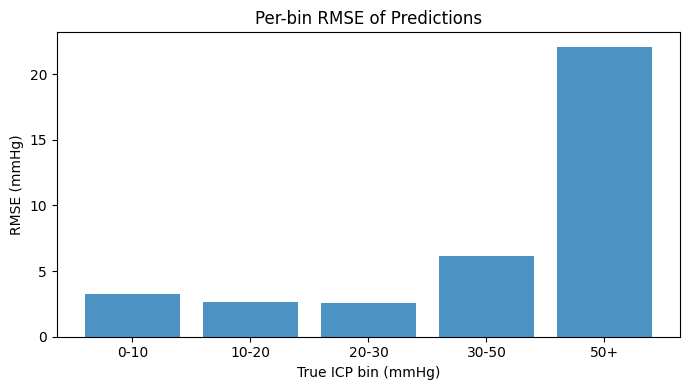

Saved: figures/per_bin_rmse.png


In [69]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare DataFrame
df_eval = pd.DataFrame({"true": y_true, "pred": y_pred})
df_eval["abs_err"] = np.abs(df_eval["true"] - df_eval["pred"])
df_eval["sq_err"] = (df_eval["true"] - df_eval["pred"])**2

# Define bins
bins = [0, 10, 20, 30, 50, np.inf]   # last bin covers >50
labels = ["0-10", "10-20", "20-30", "30-50", "50+"]

df_eval["bin"] = pd.cut(df_eval["true"], bins=bins, labels=labels, right=False)

# Compute per-bin metrics
def rmse(x): return np.sqrt(x.mean()) if len(x)>0 else np.nan
summary = df_eval.groupby("bin").agg(
    count = ("true", "size"),
    mean_true = ("true", "mean"),
    RMSE = ("sq_err", rmse),
    MAE = ("abs_err", "mean")
).reset_index()

print("Per-bin RMSE / MAE summary:")
print(summary.to_string(index=False))

# Optional: plot per-bin RMSE
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.bar(summary["bin"].astype(str), summary["RMSE"], alpha=0.8)
plt.ylabel("RMSE (mmHg)")
plt.xlabel("True ICP bin (mmHg)")
plt.title("Per-bin RMSE of Predictions")
plt.tight_layout()
fname = os.path.join(out_dir, "per_bin_rmse.png")
plt.savefig(fname, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", fname)


In [70]:
from sklearn.metrics import confusion_matrix, classification_report

thr = 20
y_true_bin = (y_true > thr).astype(int)
y_pred_bin = (y_pred > thr).astype(int)
print("\nBinary performance for ICP >", thr, "mmHg")
print(classification_report(y_true_bin, y_pred_bin, digits=3))
cm = confusion_matrix(y_true_bin, y_pred_bin)
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):")
print(cm)



Binary performance for ICP > 20 mmHg
              precision    recall  f1-score   support

           0      0.917     0.842     0.878     21059
           1      0.871     0.934     0.901     24130

    accuracy                          0.891     45189
   macro avg      0.894     0.888     0.890     45189
weighted avg      0.893     0.891     0.891     45189

Confusion matrix (rows=true 0/1, cols=pred 0/1):
[[17736  3323]
 [ 1603 22527]]


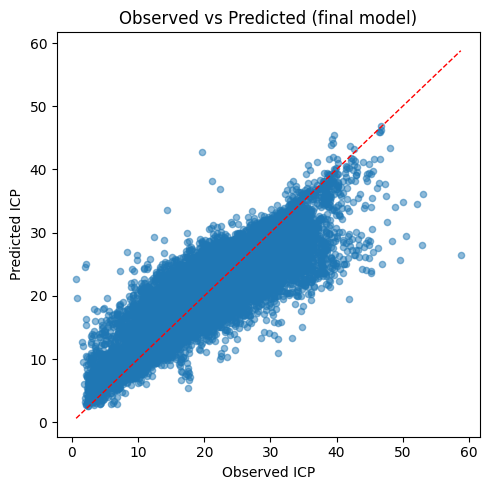

Saved: figures/observed_vs_predicted.png


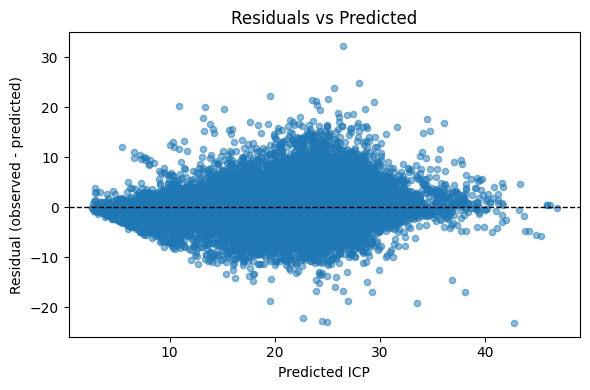

Saved: figures/residuals_vs_predicted.png


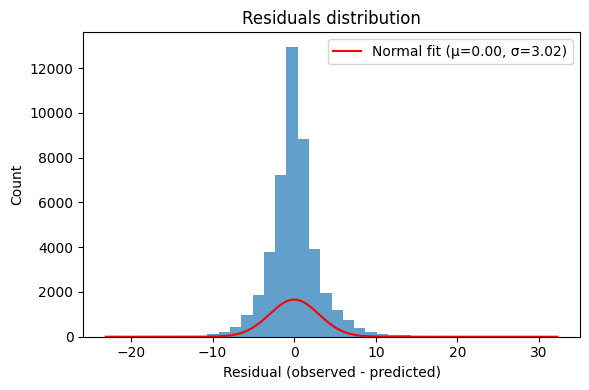

Saved: figures/residuals_hist.png


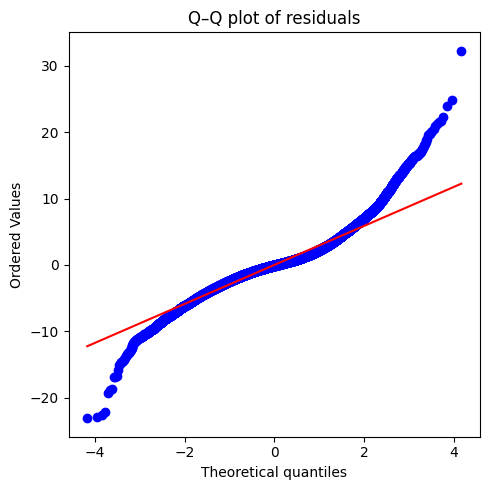

Saved: figures/residuals_qq.png

Residuals summary:
 mean = 0.001, std = 3.024
 median = -0.060, min = -23.096, max = 32.260


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os


y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred_final)
residuals = y_true - y_pred

# create output folder
out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)

# Observed vs Predicted
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel("Observed ICP")
plt.ylabel("Predicted ICP")
plt.title("Observed vs Predicted (final model)")
plt.tight_layout()
fname = os.path.join(out_dir, "observed_vs_predicted.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", fname)

# Residuals vs Predicted (check heteroscedasticity / bias)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5, s=20)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Predicted ICP")
plt.ylabel("Residual (observed - predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
fname = os.path.join(out_dir, "residuals_vs_predicted.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", fname)

# Residuals histogram + KDE
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, density=False, alpha=0.7)
# overlay normal distribution fit for reference
mu, sigma = residuals.mean(), residuals.std()
xs = np.linspace(residuals.min(), residuals.max(), 200)
plt.plot(xs, len(residuals) * (xs[1]-xs[0]) * stats.norm.pdf(xs, mu, sigma), 'r-', label=f"Normal fit (μ={mu:.2f}, σ={sigma:.2f})")
plt.xlabel("Residual (observed - predicted)")
plt.ylabel("Count")
plt.title("Residuals distribution")
plt.legend()
plt.tight_layout()
fname = os.path.join(out_dir, "residuals_hist.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", fname)

# Q-Q plot for residuals (normality check)
plt.figure(figsize=(5,5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q plot of residuals")
plt.tight_layout()
fname = os.path.join(out_dir, "residuals_qq.png")
plt.savefig(fname, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", fname)

# Quick summary printed
print("\nResiduals summary:")
print(f" mean = {residuals.mean():.3f}, std = {residuals.std():.3f}")
print(f" median = {np.median(residuals):.3f}, min = {residuals.min():.3f}, max = {residuals.max():.3f}")
